<a href="https://colab.research.google.com/github/lutzeric/textmining/blob/main/Clustering_Rayuela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio de clustering basado fuertemente en el de Dani Bosch (2017), aplicado a la novela Rayuela, de Julio Cortázar.

# Drive y bibliotecas
Acá cargo mi drive, donde tengo los archivos, y las bibliotecas que vamos a usar.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from sklearn.cluster import KMeans   

Uso el modelo de Spacy en español más pequeño, y le pido que me permita procesar más de 1 millón de palabras, que es lo que viene por defecto, para que entre la novela entera 

In [3]:
!python -m spacy download es_core_news_sm
import spacy
import es_core_news_sm

nlp = es_core_news_sm.load()
nlp.max_length = 1005000

     |████████████████████████████████| 16.2 MB 5.3 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=6c886d5af831739f3021659152ee09bc133a55b91c16cf4e5f920a75ad37b968
  Stored in directory: /tmp/pip-ephem-wheel-cache-btbhantp/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


# Procesamiento

Primero, cargo el texto de Rayuela que está en mi drive de Google y lo proceso con la función nlp de Spacy.

In [4]:
path = '/content/gdrive/MyDrive/Doctorado/rayuela.txt'
with open(path, "r") as file: # abrimos el .txt
    texto = file.read().replace("\n", " ")
    # dataset = texto.lower()
doc = nlp(texto)

Le pido que solo tenga en cuenta las oraciones de más de 5 palabras (este número es completamente arbitrario). Luego armo una vacía donde voy a poner las palabras lematizadas, sin contar números ni signos de puntuación.

In [5]:
sents = [sent for sent in doc.sents if len(sent) > 5]
words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(word.lemma_)

Usamos un diccionario de lemas, ya que el lematizador que utiliza Spacy en español sólo transforma las palabras en minúsculas. Aún así hay muchas palabras que se le escapan.

In [6]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

In [7]:
lemma_file = open('/content/gdrive/MyDrive/Doctorado/lemmatization-es.txt', "r")
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]

In [8]:
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word

Esta parte no la entiendo :-(

In [9]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
threshold_w = 100
threshold_c = 50

for word in words:
    w = lemmatize(word.lemma_)
    if not word.is_alpha or str.isdigit(w) or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    tags = parse_tags(word)
    for tag in tags:
        if not tag in features:
            features[tag] = 0
        features[tag] += 1

    if not word.i == 0:
        context_izq = doc[word.i - 1]
        c_izq = lemmatize(context_izq.lemma_)
        if context_izq.is_alpha and counts[c_izq] > threshold_c:
            if str.isdigit(c_izq):
                c_izq = "NUM__"
            if not c_izq in features:
                features[c_izq] = 0
            features[c_izq] += 1

    if not word.i < len(doc):
        context_der = doc[word.i + 1]
        c_der = lemmatize(context_der.lemma_)
        if context_der.is_alpha and counts[c_der] > threshold_c:
            if str.isdigit(c_der):
                c_der = "NUM__"
            if not c_der in features:
                features[c_der] = 0
            features[c_der] += 1

    tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

    word_id += 1

    dicc[w] = features

El diccionario se guarda en formato pickle en el Drive y luego se vuelve a cargar. Luego se le hace una limpieza que tampoco entiendo para qué está.

In [10]:
filename = '/content/gdrive/MyDrive/Doctorado/rayuela_dicc.pickle'
fileObj = open(filename, 'wb')
pickle.dump(dicc, fileObj)
fileObj.close()

In [11]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_dicc.pickle"
with open(filename, 'rb') as f:
    dicc = pickle.load(f)

In [12]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [13]:
filename = '/content/gdrive/MyDrive/Doctorado/rayuela_cleandicc.pickle'
fileObj = open(filename, 'wb')
pickle.dump(features, fileObj)
fileObj.close()

filename = "/content/gdrive/MyDrive/Doctorado/rayuela_keys.pickle"
fileObj = open(filename, 'wb')
pickle.dump(key_words, fileObj)
fileObj.close()

In [14]:
filename = '/content/gdrive/MyDrive/Doctorado/rayuela_cleandicc.pickle'
with open(filename, 'rb') as f:
    features = pickle.load(f)
    
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_keys.pickle"
with open(filename, 'rb') as f:
    key_words = pickle.load(f)

Entiendo en esta parte que se hace un vector a partir del diccionario y se genera una matriz que se guarda y luego se carga.

In [15]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [16]:
matrix_normed = matrix / matrix.max(axis=0)

In [17]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [18]:
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [19]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_matrix.pickle"
fileObj = open(filename, 'wb')
pickle.dump(red_matrix, fileObj)
fileObj.close()

In [20]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_matrix.pickle"
with open(filename, 'rb') as f:
    red_matrix = pickle.load(f)

In [21]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [22]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_matrix2d.pickle"
fileObj = open(filename, 'wb')
pickle.dump(matrix_dicc2d, fileObj)
fileObj.close()

In [23]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_matrix2d.pickle"
with open(filename, 'rb') as f:
    matrix_dicc2d = pickle.load(f)

In [24]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

Se arma una función para graficar una parte del espacio y luego se la utiliza.

In [26]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

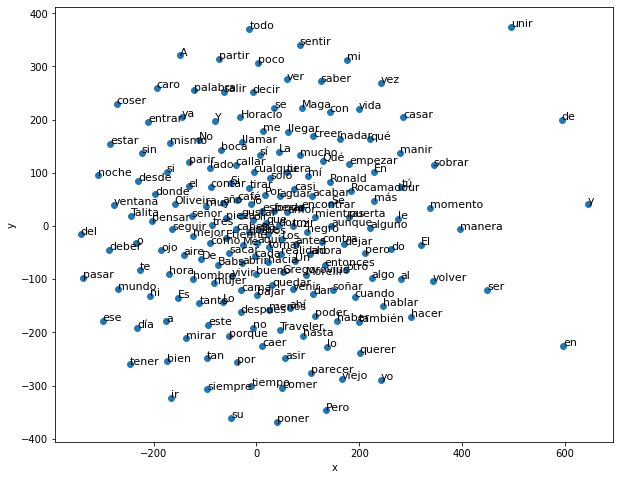

In [54]:
plot_region(x_bounds=(-700, 800), y_bounds=(-500, 400))

En esta parte utilizo una función para elegir automáticamente el número óptimo de clusters (al menos, para tener una aproximación), mediante el método del codo.

In [28]:
!pip install kneed            # instalamos el paquete con pip
from kneed import KneeLocator # importamos el paquete para detectar el codo

In [29]:
sse = [] # acá vamos a guardar el puntaje de la función objetivo

for k in range(1, 40):
  kkmeans = KMeans(n_clusters=k)
  kkmeans.fit(red_matrix)
  sse.append(kkmeans.inertia_)

In [30]:
kl = KneeLocator(range(1, 40), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)

El codo está en k = 4


En este último caso, el número óptimo de clusters dio 4. Armo un archivo pickle con los 4 clusters y lo cargo.

In [31]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [32]:
c_optimo = clustering(kl.elbow)

In [33]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_cluster_op.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c_optimo, fileObj)
fileObj.close()

In [36]:
filename = "/content/gdrive/MyDrive/Doctorado/rayuela_cluster_op.pickle"
with open(filename, 'rb') as f:
    clusters = pickle.load(f)

In [37]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

Gráfico de los puntos... no sé qué tiene de diferente al gráfico anterior, pero está basado en que son 4 clusters.

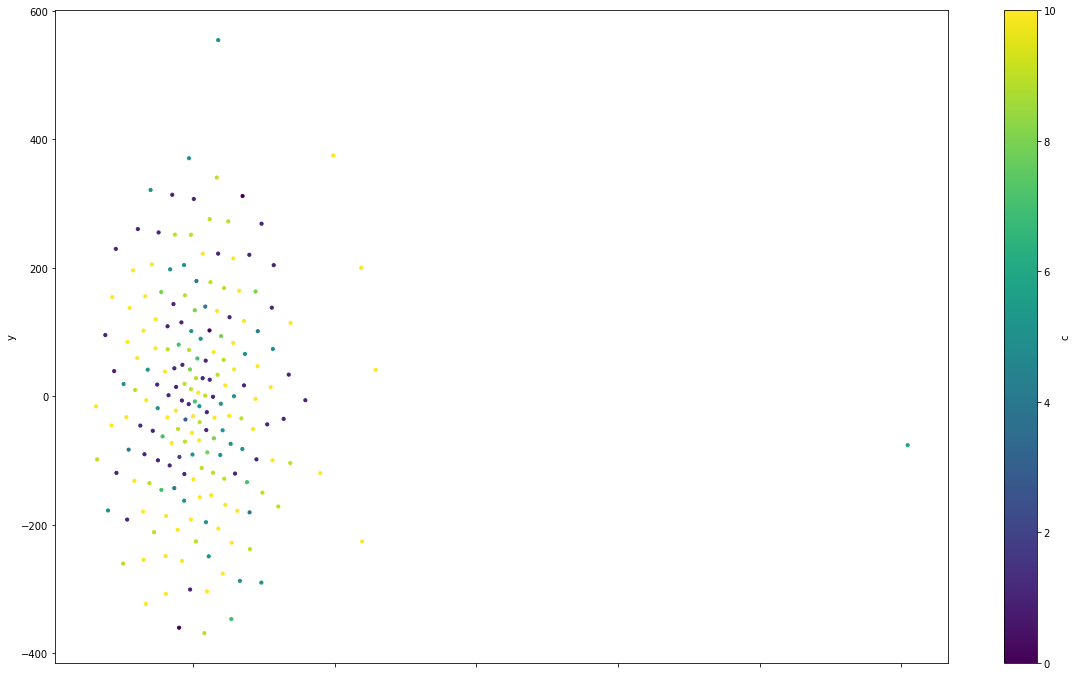

In [38]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

Acá se puede jugar a ver qué palabras quedaron cerca de una a elección. Por ejemplo, al probar con el apellido del protagonista de la novela, Oliveira, quedan junto a él nombres de otros personajes, como Traveler, Morelli, Rocamadour y Talita, sumado a su nombre de pila, Horacio. Curiosamente, el nombre de uno de los personajes más importantes del texto, Lucía "La Maga" no aparece junto a él. Posiblemente sea porque Spacy entiende que Lucía es simplemente una forma del verbo "lucir", y que "Maga" lematizada es simplemente "mago", un sustantivo común.

In [55]:
# Nombres propios cerca de Oliveira y otras palabras
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["Oliveira"]]]
print(printer)

['otro', 'Y', 'yo', 'él', 'ahora', 'viejo', 'todo', 'aunque', 'asir', 'cualquiera', 'tú', 'negro', 'entonces', 'mejor', 'ese', 'después', 'solo', 'Rocamadour', 'A', 'Horacio', 'Oliveira', 'Traveler', 'bueno', 'Vos', 'Morelli', 'Talita']


In [56]:
# Maga
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["Maga"]]]
print(printer)

['Maga', 'vez', 'luz', 'lado', 'aguar', 'callar', 'vida', 'caro', 'manera', 'do', 'casar', 'café', 'mujer', 'poco', 'manir', 'fondo', 'Qué', 'tiempo', 'momento', 'coser', 'noche', 'día', 'golpe', 'palabra', 'partir', 'hora', 'ojo', 'mundo', 'soñar', 'año', 'hombre', 'señor', 'algo', 'realidad', 'El', 'boca', 'pieza', 'amor', 'cama', 'aire', 'ventana', 'puerta', 'Los', 'tres', 'cabeza']


Probando, como hizo Dani en su notebook, si juntaba todas las stopwords, se ve que si bien algunas van juntas, están mezcladas (como también se ve más arriba) con nombres propios, como Babs, Ronald y Etienne, otros personajes de la novela.

In [59]:
# Stop words y otras
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["el"]]]
print(printer)

['a', 'el', 'haber', 'por', 'de', 'al', 'que', 'y', 'sobrar', 'lo', 'ya', 'se', 'en', 'unir', 'ser', 'tan', 'del', 'entrar', 'sin', 'comer', 'menos', 'mismo', 'parir', 'o', 'desde', 'no', 'estar', 'con', 'hasta', 'cada', 'contra', 'pero', 'parecer', 'porque', 'siempre', 'mientras', 'deber', 'poder', 'donde', 'alguno', 'antes', 'le', 'más', 'ir', 'este', 'si', 'ahí', 'seguir', 'bajar', 'casi', 'muy', 'empezar', 'nadar', 'bien', 'ni', 'hacia', 'mucho', 'Ronald', 'Etienne', 'cómo', 'Se', 'aquí', 'Babs']


# Conclusión
Hay muchas cosas que no entiendo, pero me pasa por copiar y pegar código ajeno. Principalmente, me gustaría saber por qué quedan tan pocas palabras, siendo un texto que usa más de cien mil (repetidas y todo, pero me parece poco). Hice algunas pruebas acá y allá, pero no obtuve resultados diferentes. Probé también con el notebook de Facu Molina, pero me pareció que este trabajo estaba más completo. También probé con mis propias stopwords y trabajo manual en algunas partes, pero no mejoraron los resultados. Tengo que seguir probando. Cualquier comentario es muy bienvenido. 